In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv
/kaggle/input/roberta-base/rust_model.ot
/kaggle/input/roberta-base/config.json
/kaggle/input/roberta-base/merges.txt
/kaggle/input/roberta-base/README.md
/kaggle/input/roberta-base/tokenizer.json
/kaggle/input/roberta-base/vocab.json
/kaggle/input/roberta-base/tf_model.h5
/kaggle/input/roberta-base/dict.txt
/kaggle/input/roberta-base/pytorch_model.bin
/kaggle/input/roberta-base/flax_model.msgpack
/kaggle/input/cpc-codes/titles.csv


# Config

In [2]:
model_name = "../input/roberta-base"
max_len = 40
NUM_EPOCHS = 15
batch_size=32
LR = 1e-5

# Reading the training and test datasets

In [3]:
train = pd.read_csv("../input/us-patent-phrase-to-phrase-matching/train.csv")
train.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [4]:
test = pd.read_csv("../input/us-patent-phrase-to-phrase-matching/test.csv")
test.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


# Importing *Cooperative Patent Classification Codes Meaning* dataset
More details regarding the dataset can be found [here](https://www.kaggle.com/datasets/xhlulu/cpc-codes)

In [5]:
title = pd.read_csv("../input/cpc-codes/titles.csv")
title.head()

,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...,A,1.0,NaN,NaN,NaN
2,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...,A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 ...,A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3...,A,1.0,B,1.0,2.0


# Merging the CPCC dataset with both of the training and test datasets

In [6]:
train = pd.merge(train, title[["code","title"]], 
                 left_on = "context", right_on = "code",
                 how='left')

test = pd.merge(test, title[["code","title"]], 
                 left_on = "context", right_on = "code",
                 how='left')

In [7]:
train.head()

,id,anchor,target,context,score,code,title
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...


In [8]:
test.head()

,id,anchor,target,context,code,title
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,G02,OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,F23,COMBUSTION APPARATUS; COMBUSTION PROCESSES
2,36baf228038e314b,lower trunnion,lower locating,B60,B60,VEHICLES IN GENERAL
3,1f37ead645e7f0c8,cap component,upper portion,D06,D06,TREATMENT OF TEXTILES OR THE LIKE; LAUNDERING;...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,H04,ELECTRIC COMMUNICATION TECHNIQUE


# Performing data pre-processing on the training and test set data
#### Dropping the *context* column

In [9]:
train = train.drop(["context"],axis=1)
train.head()

,id,anchor,target,score,code,title
0,37d61fd2272659b1,abatement,abatement of pollution,0.50,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
1,7b9652b17b68b7a4,abatement,act of abating,0.75,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
2,36d72442aefd8232,abatement,active catalyst,0.25,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
3,5296b0c19e1ce60e,abatement,eliminating process,0.50,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
4,54c1e3b9184cb5b6,abatement,forest region,0.00,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...


In [10]:
test = test.drop(["context"],axis=1)
test.head()

,id,anchor,target,code,title
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,COMBUSTION APPARATUS; COMBUSTION PROCESSES
2,36baf228038e314b,lower trunnion,lower locating,B60,VEHICLES IN GENERAL
3,1f37ead645e7f0c8,cap component,upper portion,D06,TREATMENT OF TEXTILES OR THE LIKE; LAUNDERING;...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRIC COMMUNICATION TECHNIQUE


**Transform the *anchor* and *target* features into lowercase.**

In [11]:
train['anchor'] = train['anchor'].str.lower()
train['target'] = train['target'].str.lower()
test['anchor'] = test['anchor'].str.lower()
test['target'] = test['target'].str.lower()
train.head()

,id,anchor,target,score,code,title
0,37d61fd2272659b1,abatement,abatement of pollution,0.50,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
1,7b9652b17b68b7a4,abatement,act of abating,0.75,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
2,36d72442aefd8232,abatement,active catalyst,0.25,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
3,5296b0c19e1ce60e,abatement,eliminating process,0.50,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
4,54c1e3b9184cb5b6,abatement,forest region,0.00,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...


**Removing punctuations from *anchor* and *target* features**

In [12]:
train['anchor'] = train['anchor'].str.replace('[^\w\s]','',regex=True)
train['target'] = train['target'].str.replace('[^\w\s]','',regex=True)
test['anchor'] = test['anchor'].str.replace('[^\w\s]','',regex=True)
test['target'] = test['target'].str.replace('[^\w\s]','',regex=True)
train.head()

,id,anchor,target,score,code,title
0,37d61fd2272659b1,abatement,abatement of pollution,0.50,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
1,7b9652b17b68b7a4,abatement,act of abating,0.75,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
2,36d72442aefd8232,abatement,active catalyst,0.25,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
3,5296b0c19e1ce60e,abatement,eliminating process,0.50,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...
4,54c1e3b9184cb5b6,abatement,forest region,0.00,A47,FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; CO...


**Removing punctutations from the *title* feature**

In [13]:
import re
train["title"] = train["title"].apply(lambda x:re.sub('[;,]', '', x))
test["title"] = test["title"].apply(lambda x:re.sub('[;,]', '', x))

In [14]:
train.head()

,id,anchor,target,score,code,title
0,37d61fd2272659b1,abatement,abatement of pollution,0.50,A47,FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...
1,7b9652b17b68b7a4,abatement,act of abating,0.75,A47,FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...
2,36d72442aefd8232,abatement,active catalyst,0.25,A47,FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...
3,5296b0c19e1ce60e,abatement,eliminating process,0.50,A47,FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...
4,54c1e3b9184cb5b6,abatement,forest region,0.00,A47,FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...


In [15]:
test.head()

,id,anchor,target,code,title
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,COMBUSTION APPARATUS COMBUSTION PROCESSES
2,36baf228038e314b,lower trunnion,lower locating,B60,VEHICLES IN GENERAL
3,1f37ead645e7f0c8,cap component,upper portion,D06,TREATMENT OF TEXTILES OR THE LIKE LAUNDERING F...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRIC COMMUNICATION TECHNIQUE


# K-fold cross validation
Implementing the stratified K-fold cross validation method in our training set. The logic behind the following code has been taken from the following Kaggle Notebook given [here](https://www.kaggle.com/code/abhishek?scriptVersionId=90918173&cellId=2)

In [16]:
from sklearn import model_selection

def create_kfold_dataset(dataset, num_splits):
    # we create a new column called kfold and fill it with -1
    dataset["kfold"] = -1
    # the next step is to randomize the rows of the data
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    
    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(dataset))))
    
    # bin targets
    dataset.loc[:, "bins"] = pd.cut(dataset["score"], bins=num_bins, labels=False)
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    
    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=dataset, y=dataset.bins.values)):
        dataset.loc[v_, 'kfold'] = f
    
    # drop the bins column
    dataset = dataset.drop("bins", axis=1)

    # return dataframe with folds
    return dataset.copy()

In [17]:
train.head()

,id,anchor,target,score,code,title
0,37d61fd2272659b1,abatement,abatement of pollution,0.50,A47,FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...
1,7b9652b17b68b7a4,abatement,act of abating,0.75,A47,FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...
2,36d72442aefd8232,abatement,active catalyst,0.25,A47,FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...
3,5296b0c19e1ce60e,abatement,eliminating process,0.50,A47,FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...
4,54c1e3b9184cb5b6,abatement,forest region,0.00,A47,FURNITURE DOMESTIC ARTICLES OR APPLIANCES COFF...


In [18]:
train = create_kfold_dataset(train.copy(), num_splits=5)
train.head()

,id,anchor,target,score,code,title,kfold
0,2b4b1a7ed5b137b7,stationary rod,movable rod,0.25,G01,MEASURING TESTING,0
1,84fdd95f30b10bef,rotary section,bluetooth portable rotary phone,0.00,B21,MECHANICAL METAL-WORKING WITHOUT ESSENTIALLY R...,3
2,7600dfcbe2832fc7,moisture proof film,light functional layer,0.00,H05,ELECTRIC TECHNIQUES NOT OTHERWISE PROVIDED FOR,2
3,9dab5cd614e78128,measure surface temperature,temperature detecting techniques,0.50,F23,COMBUSTION APPARATUS COMBUSTION PROCESSES,2
4,7ea03f90592a7821,surgical gloves,disposable gloves,0.50,C10,PETROLEUM GAS OR COKE INDUSTRIES TECHNICAL GAS...,2


In [19]:
train.kfold.value_counts()

0    7295
2    7295
1    7295
3    7294
4    7294
Name: kfold, dtype: int64

# Intializing the tokenizer
**We use the deberta v2 large model from huggingface**

In [20]:
# Intializing the deberta tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [21]:
tokenizer

PreTrainedTokenizerFast(name_or_path='../input/roberta-base', vocab_size=50265, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)})

In [22]:
# The tokenized output shown below
encoded_input = tokenizer(train['target'][0])
print(encoded_input)

{'input_ids': [0, 119, 30289, 21966, 2], 'attention_mask': [1, 1, 1, 1, 1]}


In [23]:
# Saving the model in the output folder
#tokenizer.save_pretrained("./roberta_base/")

In [24]:
train.head()

,id,anchor,target,score,code,title,kfold
0,2b4b1a7ed5b137b7,stationary rod,movable rod,0.25,G01,MEASURING TESTING,0
1,84fdd95f30b10bef,rotary section,bluetooth portable rotary phone,0.00,B21,MECHANICAL METAL-WORKING WITHOUT ESSENTIALLY R...,3
2,7600dfcbe2832fc7,moisture proof film,light functional layer,0.00,H05,ELECTRIC TECHNIQUES NOT OTHERWISE PROVIDED FOR,2
3,9dab5cd614e78128,measure surface temperature,temperature detecting techniques,0.50,F23,COMBUSTION APPARATUS COMBUSTION PROCESSES,2
4,7ea03f90592a7821,surgical gloves,disposable gloves,0.50,C10,PETROLEUM GAS OR COKE INDUSTRIES TECHNICAL GAS...,2


# Creating Phrase dataset for the model training

In [25]:
def create_data(id_, anchor, target, code, title, score, tokenizer, max_len, train_status=True):
    input_ids = []
    attention_mask = []
    token_type_ids = []
    labels = []
    ids = []
    encoded_sent = tokenizer.batch_encode_plus([(k[0] + " " + k[2], k[1]) for k in zip(anchor,target,title)],\
                                                max_length = max_len,\
                                                padding = "max_length", truncation = True)
    for i in range(len(anchor)): 
        ids.append(id_[i])
        input_ids.append(encoded_sent['input_ids'][i])
        attention_mask.append(encoded_sent['attention_mask'][i])
        if train_status:
            labels.append(score[i])
    return {"input_ids":input_ids,
            "attention_mask":attention_mask,
            "ids":ids, 
            }, labels

# Creating the training Model
We first create a basic deep learning model. More explaination will be given later.

In [26]:
import tensorflow as tf

def build_model(model_name, MAX_LEN):
    
    input__ids = tf.keras.Input(shape=(MAX_LEN, ), dtype = tf.int32)
    input__mask = tf.keras.Input(shape=(MAX_LEN, ), dtype = tf.int32)
    
    transformer = TFAutoModel.from_pretrained(model_name, trainable=True)
    x = transformer(input_ids = input__ids, 
                      attention_mask = input__mask)
    #print(x.last_hidden_state)
    x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)
    x = tf.keras.layers.Dropout(0.3)(x)

    fnl = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs = [input__ids, input__mask], 
                           outputs = fnl)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LR), loss = "mse")
    return model

# Creating the validation and training set for model training purpose

In [27]:
fld = 0

train_data, train_labels = create_data(train[train.kfold != fld]['id'].tolist(), 
                                       train[train.kfold != fld]['anchor'].tolist(), 
                                       train[train.kfold != fld]['target'].tolist(),
                                       train[train.kfold != fld]['code'].tolist(),
                                       train[train.kfold != fld]['title'].tolist(), 
                                       train[train.kfold != fld]['score'].tolist(), 
                                       tokenizer, max_len, train_status=True)

val_data, val_labels = create_data(train[train.kfold == fld]['id'].tolist(), 
                                       train[train.kfold == fld]['anchor'].tolist(), 
                                       train[train.kfold == fld]['target'].tolist(),
                                       train[train.kfold == fld]['code'].tolist(),
                                       train[train.kfold == fld]['title'].tolist(), 
                                       train[train.kfold == fld]['score'].tolist(), 
                                       tokenizer, max_len, train_status=True)


# Creating the callback Pearson Correlation coefficient as a tracking metrics for the model 

In [28]:
from scipy.stats import pearsonr

class PearsonCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
    #    pass
        #print(dir(self.model))
        self.X_val, self.Y_val = val_data
    #def on_epoch_start(self,epoch):
    #    print(f"Learning rate: {self.model.optimize.learning_rate}")
    def on_epoch_end(self, epoch, logs):
        X_val_preds = self.model.predict(self.X_val)
        #print(X_val_preds.shape,self.Y_val.shape)
        pearson_corr = pearsonr(X_val_preds.ravel(), self.Y_val)
        print("pearsonr_val (from log) =", pearson_corr[0])
        logs["val_pearsonr"] = pearson_corr[0]

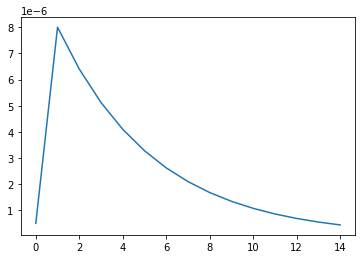

In [29]:
import matplotlib.pyplot as plt

def scheduler(epoch):
    learning_rate = LR
    if epoch == 0:
        return learning_rate * 0.05
    else:
        return learning_rate * (0.8**epoch)
    
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

plt.plot([scheduler(e) for e in range(NUM_EPOCHS)])

In [30]:
callback_save = tf.keras.callbacks.ModelCheckpoint('roberta_patent.h5', monitor='val_pearsonr',\
                                                   verbose=1, save_best_only=True,\
                                                   save_weights_only=True, mode='max',\
                                                   save_freq='epoch')
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_pearsonr', patience=2, mode='max',\
                                               verbose=1, restore_best_weights=True)
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_pearsonr',factor=np.sqrt(0.1),\
                                                  cooldown=0, patience=2, min_lr=0.5e-9,mode='max')
model = build_model(model_name, max_len)

2022-04-22 05:59:08.826655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 05:59:08.827773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 05:59:08.828506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-22 05:59:08.829334: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Fitting the model to the training dataset

In [31]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_roberta_model[0][0]       

In [32]:
val_data_ = ((np.asarray(val_data['input_ids']),
              np.asarray(val_data['attention_mask']),
             ),
             np.asarray(val_labels).ravel())

model.fit((np.asarray(train_data['input_ids']),
           np.asarray(train_data['attention_mask']),
          ),
          np.asarray(train_labels).ravel(), 
        epochs = NUM_EPOCHS,
        shuffle=True,
        callbacks = [callback_lr,PearsonCallback(val_data_), callback_save, callback_es],
        batch_size = batch_size,
        validation_data= val_data_
       )

# model.fit((np.asarray(train_data['input_ids']),
#            np.asarray(train_data['attention_mask']),
#           ),
#           np.asarray(train_labels).ravel(), 
#         epochs = NUM_EPOCHS,
#         shuffle=True,
#         callbacks = [lr_reducer, callback_save, callback_es, PearsonCallback(val_data_)],
#         batch_size = batch_size,
#         validation_data= val_data_
#        )

2022-04-22 05:59:27.037745: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
912/912 [==============================] - 198s 201ms/step - loss: 0.1220 - val_loss: 0.0581
pearsonr_val (from log) = 0.3819127312105647

Epoch 00001: val_pearsonr improved from -inf to 0.38191, saving model to roberta_patent.h5
Epoch 2/15
912/912 [==============================] - 181s 199ms/step - loss: 0.0666 - val_loss: 0.0400
pearsonr_val (from log) = 0.6531991469882968

Epoch 00002: val_pearsonr improved from 0.38191 to 0.65320, saving model to roberta_patent.h5
Epoch 3/15
912/912 [==============================] - 181s 199ms/step - loss: 0.0473 - val_loss: 0.0391
pearsonr_val (from log) = 0.7113091170634731

Epoch 00003: val_pearsonr improved from 0.65320 to 0.71131, saving model to roberta_patent.h5
Epoch 4/15
912/912 [==============================] - 181s 199ms/step - loss: 0.0398 - val_loss: 0.0325
pearsonr_val (from log) = 0.7310182221387311

Epoch 00004: val_pearsonr improved from 0.71131 to 0.73102, saving model to roberta_patent.h5
Epoch 5/15
912/912 [=======

# Predicting the test set results

In [33]:
test_data, test_labels = create_data(test['id'].tolist(),\
                                   test['anchor'].tolist(),\
                                   test['target'].tolist(),\
                                   test['code'].tolist(),\
                                   test['title'].tolist(),\
                                   None, tokenizer, max_len,\
                                   train_status=False)

In [34]:
test_preds = model.predict((np.asarray(test_data['input_ids']),
                            np.asarray(test_data['attention_mask']),
                           #np.asarray(test_data['token_type_ids']),
                           ))

In [35]:
test_preds

array([[ 6.1005753e-01],
       [ 8.5521871e-01],
       [ 2.0407560e-01],
       [ 2.6365814e-01],
       [ 2.4257931e-01],
       [ 4.7400922e-01],
       [ 4.1019449e-01],
       [-5.0338078e-04],
       [ 2.2838418e-01],
       [ 1.0497779e+00],
       [ 2.9790345e-01],
       [ 2.1068585e-01],
       [ 6.9685984e-01],
       [ 6.7284077e-01],
       [ 7.6812857e-01],
       [ 3.1672278e-01],
       [ 1.3451140e-01],
       [ 8.9122448e-05],
       [ 4.0764248e-01],
       [ 2.6525748e-01],
       [ 3.0685312e-01],
       [ 1.9866528e-01],
       [ 1.6435044e-01],
       [ 2.2098289e-01],
       [ 4.6212161e-01],
       [-1.0836915e-02],
       [-2.2173997e-02],
       [-2.0782810e-02],
       [ 4.8325799e-02],
       [ 6.8045014e-01],
       [ 2.1260248e-01],
       [ 1.2664926e-01],
       [ 5.5845058e-01],
       [ 5.1544595e-01],
       [ 3.5350189e-01],
       [ 2.0321806e-01]], dtype=float32)

# Creating the submission file

In [36]:
submission = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv")
submission['score'] = test_preds
submission['score'] = submission.score.apply(lambda x: 0 if x < 0 else x)
submission['score'] = submission.score.apply(lambda x: 1 if x > 1 else x)
submission.to_csv('submission.csv',index=False)
submission

,id,score
0,4112d61851461f60,0.610058
1,09e418c93a776564,0.855219
2,36baf228038e314b,0.204076
3,1f37ead645e7f0c8,0.263658
4,71a5b6ad068d531f,0.242579
5,474c874d0c07bd21,0.474009
6,442c114ed5c4e3c9,0.410194
7,b8ae62ea5e1d8bdb,0.000000
8,faaddaf8fcba8a3f,0.228384
9,ae0262c02566d2ce,1.000000
